# <center><b> Customer Segmentation</center>

In [1]:
# use to visualize missing value
!pip install missingno

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# clustering algorithms
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:

customer_df = pd.read_csv("/content/Mall_Customers.csv")

 # **Exploratory Data Analysis**


In [5]:
customer_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
customer_df.shape

(200, 5)

In [7]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
customer_df.describe(include='all')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


In [9]:
customer_dtype = customer_df.dtypes
customer_dtype.value_counts()

int64     4
object    1
Name: count, dtype: int64

In [11]:
customer_df.isnull().sum().sort_values(ascending = False)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Visualize missing value using **Misingno** - Train Data

<Axes: >

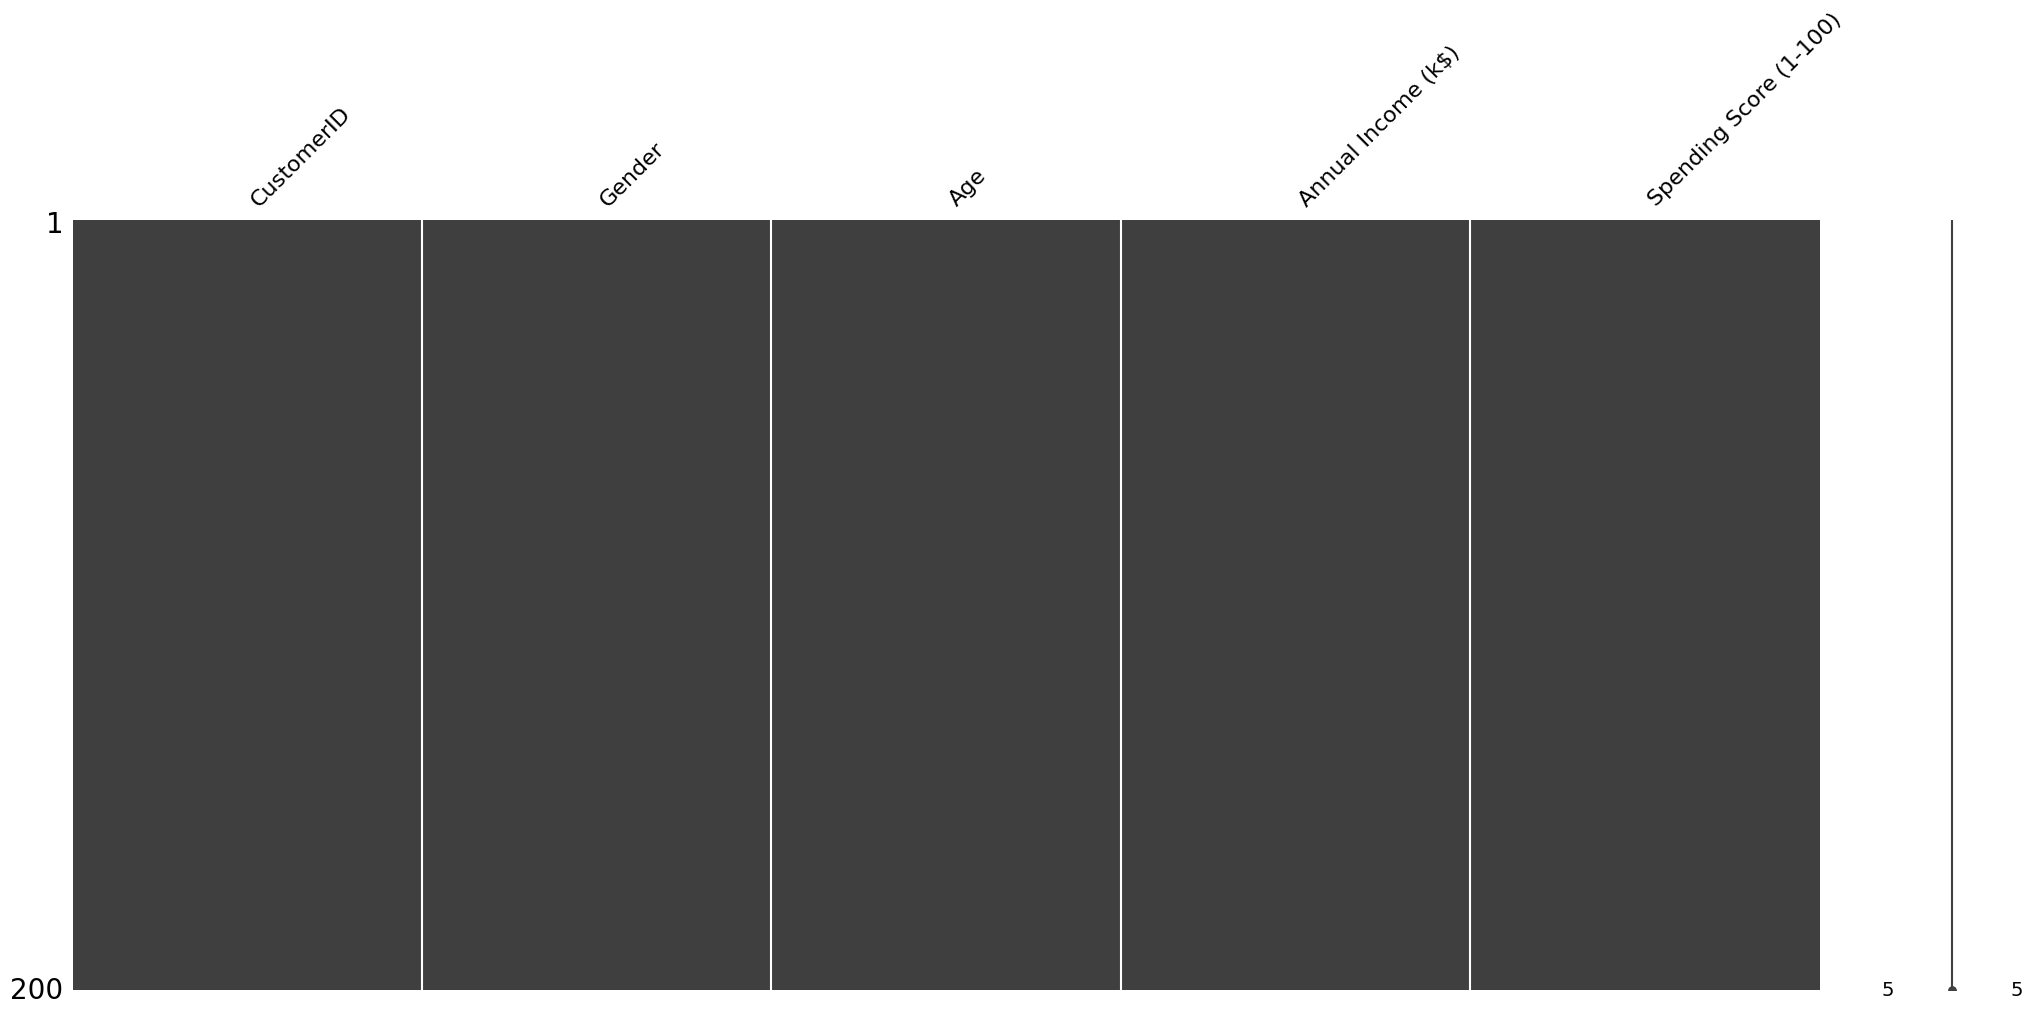

In [12]:
msno.matrix(customer_df)


 There is no missing value present


In [16]:
numerical_features = [col for col in customer_df.columns if customer_df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(customer_df[col].unique()) < 10 and col not in ['CustomerID']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['CustomerID']]
categorical_features = [col for col in customer_df.columns if customer_df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of categorical features : ",len(categorical_features))

Total Number of Numerical Columns :  4
Number of discrete features :  0
No of continuous features are :  3
Number of categorical features :  1


<ipython-input-17-8c3f32bd238c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 , 3 , pos)
<ipython-input-17-8c3f32bd238c>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=customer_df, x = feature,kde=True,palette="husl") # ax=axes[i%2, i//2]
<ipython-input-17-8c3f32bd238c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 , 3 , pos)
<ipython-input-17-8c3f32bd238c>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=customer_df, x = feature,kde=True,palette="husl") # ax=axes[i%2, i//2]
<ipython-input-17-8c3f32bd238c>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax

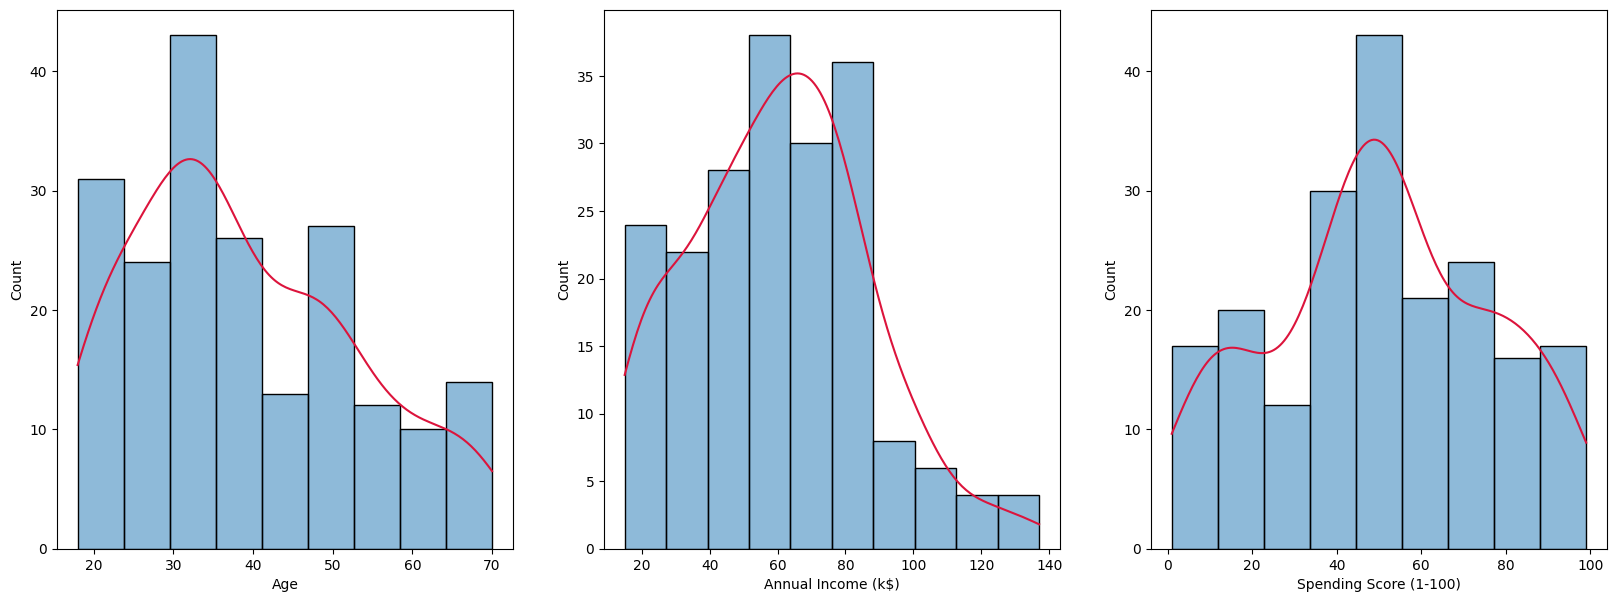

In [17]:
f, axes = plt.subplots(2,2 , figsize=(20, 7), sharex=False)
pos = 1
for i, feature in enumerate(continuous_features):

  plt.subplot(1 , 3 , pos)
  ax = sns.histplot(data=customer_df, x = feature,kde=True,palette="husl") # ax=axes[i%2, i//2]
  ax.lines[0].set_color('crimson')
  pos = pos + 1

In [19]:
# get the features except object types
numeric_feats = customer_df.dtypes[customer_df.dtypes != 'object'].index

# check the skew of all numerical features
skewed_feats = customer_df[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numerical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(10))


 Skew in numerical features: 

                            Skew
Age                     0.481919
Annual Income (k$)      0.319424
CustomerID              0.000000
Spending Score (1-100) -0.046865


Above distribution shows that:
- The distribution of continuous features are normally distributed.


<ipython-input-20-71af16622605>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=customer_df, palette="Set3")


<Axes: xlabel='Gender', ylabel='count'>

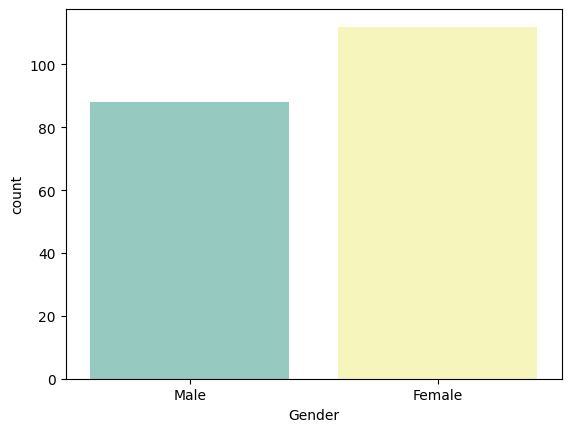

In [20]:
sns.countplot(x='Gender', data=customer_df, palette="Set3")

- Let's see how gender of customers affects to all other features.

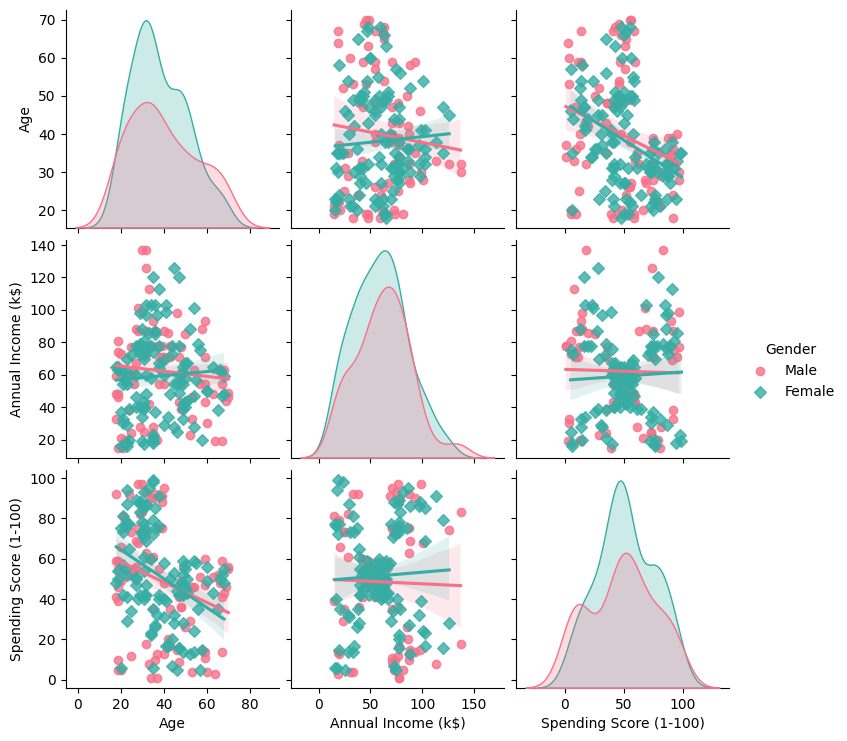

In [23]:
#Pairplot
sns.pairplot(customer_df, vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"],  kind ="reg", hue = "Gender", palette="husl", markers = ['o','D'])

- From the above pairplot we observe that green colour has higher ratio than pink colour as there are more female customers than male.





Data Correlation

Categorical columns: Index([], dtype='object')


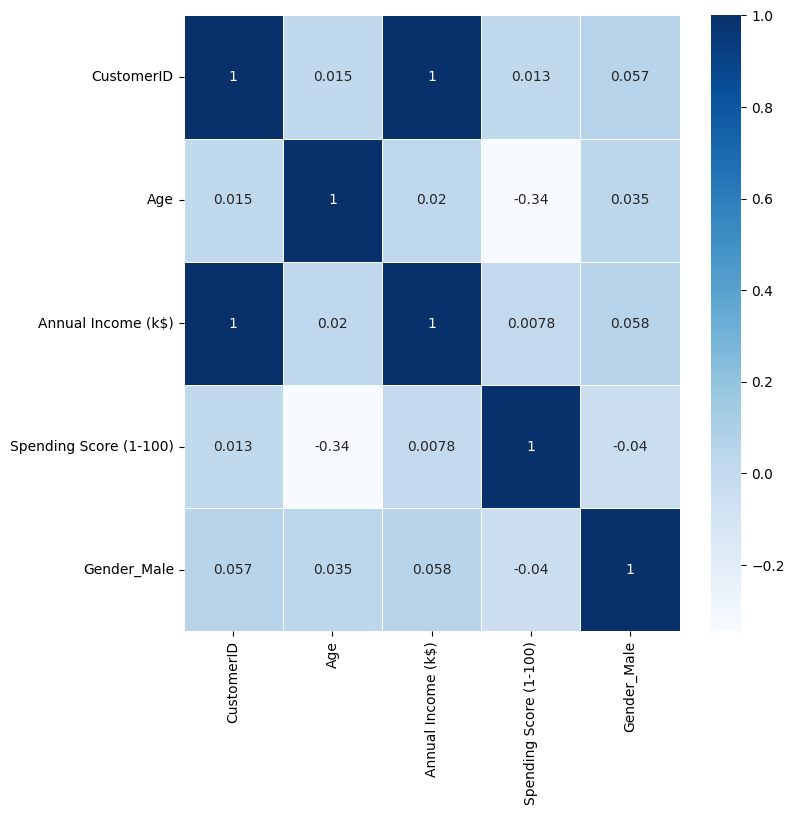

In [28]:
categorical_columns = customer_df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Convert categorical columns to numerical using one-hot encoding if necessary
customer_df = pd.get_dummies(customer_df, drop_first=True)

# Recalculate correlation matrix if needed after encoding
customer_corr = customer_df.corr(method='spearman')

# Plot the heatmap again
plt.figure(figsize=(8, 8))
sns.heatmap(customer_corr, cmap="Blues", linewidths=.5, annot=True)
plt.show()

#**Feature Engineering**

In [29]:
customer_df.drop(columns='CustomerID',axis=1,inplace=True)

Encoding Categorical Features

In [32]:
# Generate one-hot dummy columns
customer_df = pd.get_dummies(customer_df).reset_index(drop=True)

Normalization

In [33]:
# pre_precessing_pipeline = make_pipeline(RobustScaler())

# customer_scaled_df = pre_precessing_pipeline.fit_transform(customer_df)

# print(customer_scaled_df.shape)

# **Model Development**

In this step we'll apply various clustering algorithms and check which algorithm is best for our dataset. We'r going to use below algorithms.

- Kmeans Clustering
- Agglomerative Clustering
- GaussianMixture Model based clustering
- DBSCAN Clustering


### Hyperparameter tuning

To find the best K value there are many techniques we can use.

 **Elbow Method**: The elbow method finds the value of the optimal number of clusters using the total within-cluster sum of square values.

 Here we'll use **Elbow Method** to find the best K Value.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

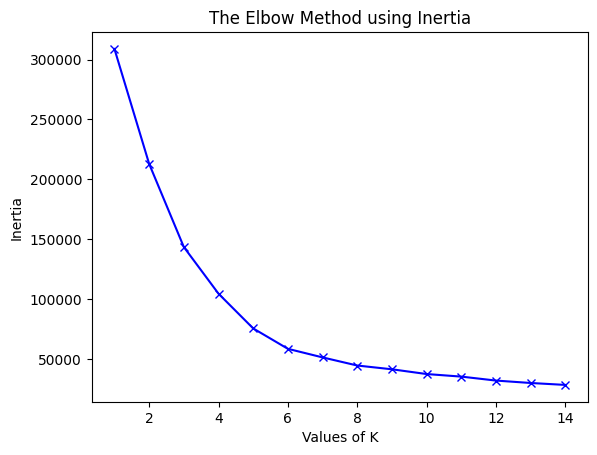

In [34]:
inertia = []
range_val = range(1,15)
for i in range_val:
  kmean = KMeans(n_clusters=i)
  kmean.fit_predict(pd.DataFrame(customer_df))
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

- From the above elbow method we see that **K = 5** is the best K value for our clustering

###  K-Means Clustering

In [35]:
# apply kmeans algorithm
kmeans_model=KMeans(5)
kmeans_clusters = kmeans_model.fit_predict(customer_df)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Agglomerative Clustering

In [40]:
# apply agglomerative algorithm
agglo_model = AgglomerativeClustering(linkage="ward",n_clusters=5)
agglomerative_clusters = agglo_model.fit_predict(customer_df)

### GaussianMixture Model based clustering

In [41]:
GaussianMixture_model = GaussianMixture(n_components=5)
gmm_clusters = GaussianMixture_model.fit_predict(customer_df)

### DBSCAN Clustering

In [42]:
model_dbscan = DBSCAN(eps=3, min_samples=17)
dbscan_clusters = model_dbscan.fit_predict(customer_df)





- **Here we'll use silhouette score method to choose the best clustering algorithm. Objects with a high silhouette value are considered well clustered"**

In [43]:
def silhouette_method(df,algo,y_pred):
  print('=================================================================================')
  print('Clustering ',algo," : silhouette score : ",silhouette_score(df,y_pred) )


silhouette_method(customer_df,' : KMeans',kmeans_clusters)
silhouette_method(customer_df,' : Agglomerative',agglomerative_clusters)
silhouette_method(customer_df,' : GaussianMixture',gmm_clusters)
print('=================================================================================')

Clustering   : KMeans  : silhouette score :  0.4440669204743008
Clustering   : Agglomerative  : silhouette score :  0.43997527212476695
Clustering   : GaussianMixture  : silhouette score :  0.4162031207414105


- From the above analysis,we saw that "K-Means" algorithm has high silhouette score as compared to others. So we'll apply K-Means algorithm for our model.

### Cluster Visualization

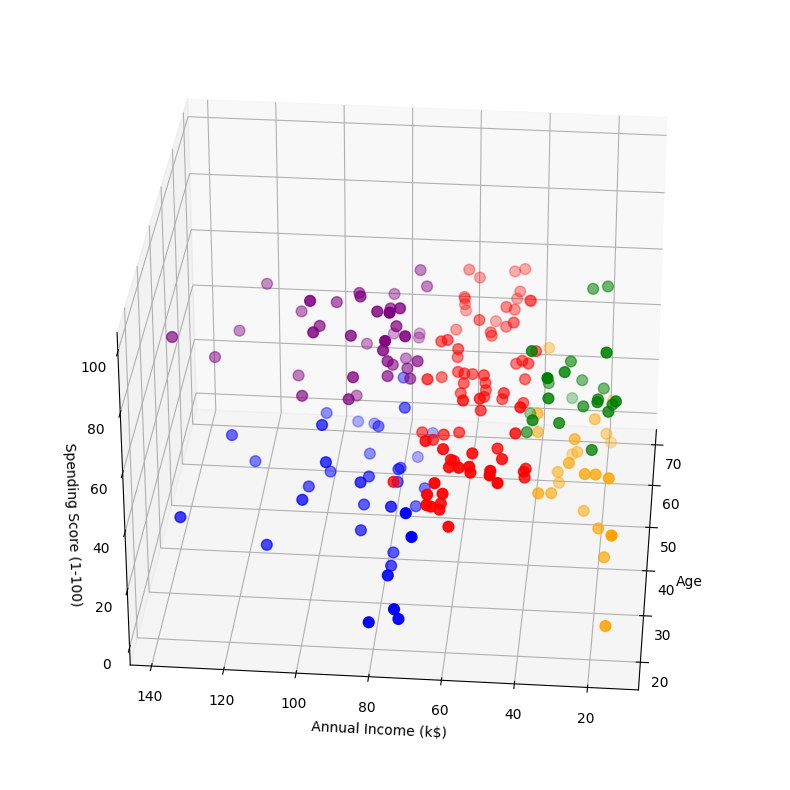

In [45]:
customer_df["label"] = kmeans_clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customer_df.Age[customer_df.label == 0], customer_df["Annual Income (k$)"][customer_df.label == 0], customer_df["Spending Score (1-100)"][customer_df.label == 0], c='blue', s=60)
ax.scatter(customer_df.Age[customer_df.label == 1], customer_df["Annual Income (k$)"][customer_df.label == 1], customer_df["Spending Score (1-100)"][customer_df.label == 1], c='red', s=60)
ax.scatter(customer_df.Age[customer_df.label == 2], customer_df["Annual Income (k$)"][customer_df.label == 2], customer_df["Spending Score (1-100)"][customer_df.label == 2], c='green', s=60)
ax.scatter(customer_df.Age[customer_df.label == 3], customer_df["Annual Income (k$)"][customer_df.label == 3], customer_df["Spending Score (1-100)"][customer_df.label == 3], c='orange', s=60)
ax.scatter(customer_df.Age[customer_df.label == 4], customer_df["Annual Income (k$)"][customer_df.label == 4], customer_df["Spending Score (1-100)"][customer_df.label == 4], c='purple', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()